# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

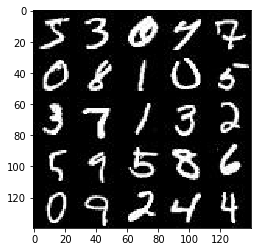

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

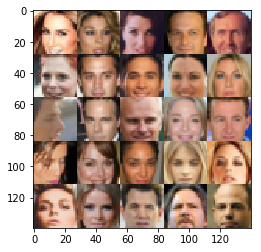

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\MiniConda\envs\dlnd\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [65]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [152]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    is_training = True
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        conv1 = tf.maximum(alpha * conv1, conv1)

        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='SAME')
        conv2 = tf.layers.dropout(conv2, rate=0.7, training=is_training)
        conv2 = tf.nn.relu(conv2)

        flattened = tf.reshape(conv2, (-1, 7 * 7 * 128))
        logits = tf.layers.dense(flattened, 1)
        
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [153]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        inputs = tf.layers.dense(z, 7 * 7 * 128)
        
        conv1 = tf.reshape(inputs, (-1, 7, 7, 128))        
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 64, 5, strides=2, padding='SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding='SAME')
        
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [154]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, False)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [155]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [156]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [157]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            
            steps = 0
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_real_scaled = batch_images * 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_real_scaled, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate, input_real: batch_real_scaled})
                
                if steps % 10 == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_real_scaled})
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print('Epoch: {}/{}({})...'.format(epoch_i+1, epochs, steps),
                         'Discriminator Loss: {:4f}...'.format(d_train_loss),
                         'Generator Loss: {:4f}'.format(g_train_loss))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)                   
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2(10)... Discriminator Loss: 1.082339... Generator Loss: 0.591995
Epoch: 1/2(20)... Discriminator Loss: 1.190300... Generator Loss: 0.511255
Epoch: 1/2(30)... Discriminator Loss: 1.159661... Generator Loss: 0.607984
Epoch: 1/2(40)... Discriminator Loss: 1.257203... Generator Loss: 0.602051
Epoch: 1/2(50)... Discriminator Loss: 1.128456... Generator Loss: 0.753720
Epoch: 1/2(60)... Discriminator Loss: 1.217455... Generator Loss: 0.643262
Epoch: 1/2(70)... Discriminator Loss: 1.175400... Generator Loss: 0.685142
Epoch: 1/2(80)... Discriminator Loss: 1.222515... Generator Loss: 0.674957
Epoch: 1/2(90)... Discriminator Loss: 1.166309... Generator Loss: 0.823759
Epoch: 1/2(100)... Discriminator Loss: 1.094638... Generator Loss: 0.813723


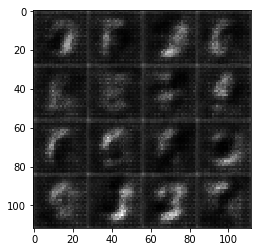

Epoch: 1/2(110)... Discriminator Loss: 1.129461... Generator Loss: 0.818049
Epoch: 1/2(120)... Discriminator Loss: 1.107711... Generator Loss: 0.776224
Epoch: 1/2(130)... Discriminator Loss: 1.217471... Generator Loss: 1.074928
Epoch: 1/2(140)... Discriminator Loss: 1.189569... Generator Loss: 0.933871
Epoch: 1/2(150)... Discriminator Loss: 1.149972... Generator Loss: 0.905065
Epoch: 1/2(160)... Discriminator Loss: 1.190124... Generator Loss: 0.877389
Epoch: 1/2(170)... Discriminator Loss: 1.227095... Generator Loss: 0.913239
Epoch: 1/2(180)... Discriminator Loss: 1.210816... Generator Loss: 0.746917
Epoch: 1/2(190)... Discriminator Loss: 1.402677... Generator Loss: 0.591160
Epoch: 1/2(200)... Discriminator Loss: 1.214895... Generator Loss: 0.814947


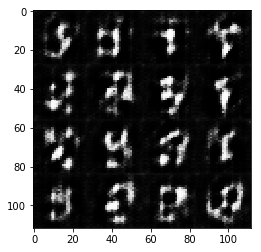

Epoch: 1/2(210)... Discriminator Loss: 1.325718... Generator Loss: 0.870311
Epoch: 1/2(220)... Discriminator Loss: 1.394195... Generator Loss: 0.705251
Epoch: 1/2(230)... Discriminator Loss: 1.393190... Generator Loss: 0.738385
Epoch: 1/2(240)... Discriminator Loss: 1.365142... Generator Loss: 0.638833
Epoch: 1/2(250)... Discriminator Loss: 1.267931... Generator Loss: 0.761859
Epoch: 1/2(260)... Discriminator Loss: 1.352677... Generator Loss: 0.662707
Epoch: 1/2(270)... Discriminator Loss: 1.316243... Generator Loss: 0.864369
Epoch: 1/2(280)... Discriminator Loss: 1.356081... Generator Loss: 0.720881
Epoch: 1/2(290)... Discriminator Loss: 1.246516... Generator Loss: 0.774989
Epoch: 1/2(300)... Discriminator Loss: 1.248824... Generator Loss: 0.855250


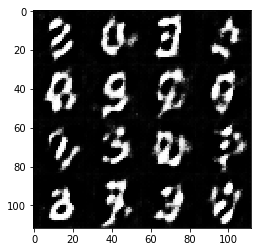

Epoch: 1/2(310)... Discriminator Loss: 1.257749... Generator Loss: 0.685560
Epoch: 1/2(320)... Discriminator Loss: 1.215794... Generator Loss: 0.933945
Epoch: 1/2(330)... Discriminator Loss: 1.285837... Generator Loss: 0.640180
Epoch: 1/2(340)... Discriminator Loss: 1.311069... Generator Loss: 0.663827
Epoch: 1/2(350)... Discriminator Loss: 1.332597... Generator Loss: 0.637694
Epoch: 1/2(360)... Discriminator Loss: 1.307655... Generator Loss: 0.734257
Epoch: 1/2(370)... Discriminator Loss: 1.298940... Generator Loss: 0.717145
Epoch: 1/2(380)... Discriminator Loss: 1.221267... Generator Loss: 0.745985
Epoch: 1/2(390)... Discriminator Loss: 1.385285... Generator Loss: 0.756723
Epoch: 1/2(400)... Discriminator Loss: 1.237263... Generator Loss: 0.691664


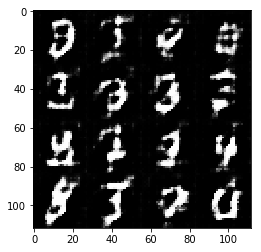

Epoch: 1/2(410)... Discriminator Loss: 1.306956... Generator Loss: 0.719818
Epoch: 1/2(420)... Discriminator Loss: 1.238802... Generator Loss: 0.745129
Epoch: 1/2(430)... Discriminator Loss: 1.332140... Generator Loss: 0.701044
Epoch: 1/2(440)... Discriminator Loss: 1.235379... Generator Loss: 0.784612
Epoch: 1/2(450)... Discriminator Loss: 1.268721... Generator Loss: 0.688836
Epoch: 1/2(460)... Discriminator Loss: 1.312508... Generator Loss: 0.739877
Epoch: 1/2(470)... Discriminator Loss: 1.295168... Generator Loss: 0.686369
Epoch: 1/2(480)... Discriminator Loss: 1.190363... Generator Loss: 0.841542
Epoch: 1/2(490)... Discriminator Loss: 1.260878... Generator Loss: 0.663195
Epoch: 1/2(500)... Discriminator Loss: 1.331808... Generator Loss: 0.741852


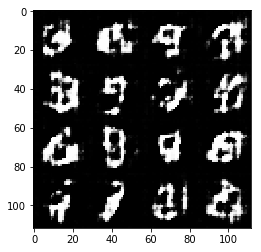

Epoch: 1/2(510)... Discriminator Loss: 1.218190... Generator Loss: 0.736993
Epoch: 1/2(520)... Discriminator Loss: 1.275305... Generator Loss: 0.826294
Epoch: 1/2(530)... Discriminator Loss: 1.246041... Generator Loss: 1.044290
Epoch: 1/2(540)... Discriminator Loss: 1.192039... Generator Loss: 0.738545
Epoch: 1/2(550)... Discriminator Loss: 1.246917... Generator Loss: 0.730945
Epoch: 1/2(560)... Discriminator Loss: 1.233760... Generator Loss: 0.791508
Epoch: 1/2(570)... Discriminator Loss: 1.325483... Generator Loss: 0.631310
Epoch: 1/2(580)... Discriminator Loss: 1.198421... Generator Loss: 0.919797
Epoch: 1/2(590)... Discriminator Loss: 1.276804... Generator Loss: 0.825645
Epoch: 1/2(600)... Discriminator Loss: 1.204887... Generator Loss: 0.806349


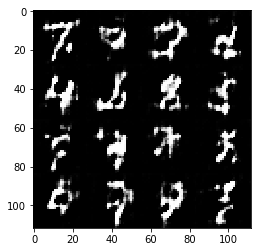

Epoch: 1/2(610)... Discriminator Loss: 1.152097... Generator Loss: 0.919053
Epoch: 1/2(620)... Discriminator Loss: 1.198706... Generator Loss: 0.753860
Epoch: 1/2(630)... Discriminator Loss: 1.181516... Generator Loss: 0.863800
Epoch: 1/2(640)... Discriminator Loss: 1.209039... Generator Loss: 0.872891
Epoch: 1/2(650)... Discriminator Loss: 1.334520... Generator Loss: 0.777762
Epoch: 1/2(660)... Discriminator Loss: 1.183480... Generator Loss: 0.791030
Epoch: 1/2(670)... Discriminator Loss: 1.263849... Generator Loss: 0.848936
Epoch: 1/2(680)... Discriminator Loss: 1.243372... Generator Loss: 0.723277
Epoch: 1/2(690)... Discriminator Loss: 1.177059... Generator Loss: 0.839087
Epoch: 1/2(700)... Discriminator Loss: 1.239694... Generator Loss: 0.877494


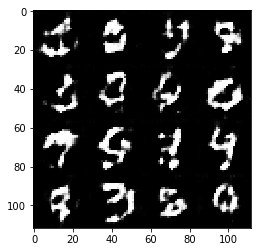

Epoch: 1/2(710)... Discriminator Loss: 1.124393... Generator Loss: 0.882729
Epoch: 1/2(720)... Discriminator Loss: 1.124222... Generator Loss: 0.903937
Epoch: 1/2(730)... Discriminator Loss: 1.184757... Generator Loss: 0.939585
Epoch: 1/2(740)... Discriminator Loss: 1.024385... Generator Loss: 0.988210
Epoch: 1/2(750)... Discriminator Loss: 1.191368... Generator Loss: 0.882647
Epoch: 1/2(760)... Discriminator Loss: 1.205311... Generator Loss: 0.885984
Epoch: 1/2(770)... Discriminator Loss: 1.201959... Generator Loss: 1.055139
Epoch: 1/2(780)... Discriminator Loss: 1.373222... Generator Loss: 0.495420
Epoch: 1/2(790)... Discriminator Loss: 1.213539... Generator Loss: 1.028250
Epoch: 1/2(800)... Discriminator Loss: 1.101510... Generator Loss: 0.888913


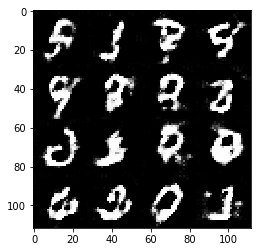

Epoch: 1/2(810)... Discriminator Loss: 1.133892... Generator Loss: 0.920520
Epoch: 1/2(820)... Discriminator Loss: 1.129809... Generator Loss: 0.968676
Epoch: 1/2(830)... Discriminator Loss: 1.051442... Generator Loss: 0.889391
Epoch: 1/2(840)... Discriminator Loss: 1.200327... Generator Loss: 0.919422
Epoch: 1/2(850)... Discriminator Loss: 1.046685... Generator Loss: 1.023784
Epoch: 1/2(860)... Discriminator Loss: 1.193308... Generator Loss: 0.661643
Epoch: 1/2(870)... Discriminator Loss: 1.130938... Generator Loss: 0.938287
Epoch: 1/2(880)... Discriminator Loss: 1.071191... Generator Loss: 0.755477
Epoch: 1/2(890)... Discriminator Loss: 1.207786... Generator Loss: 0.878565
Epoch: 1/2(900)... Discriminator Loss: 1.109453... Generator Loss: 1.008081


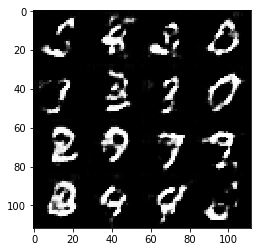

Epoch: 1/2(910)... Discriminator Loss: 1.108205... Generator Loss: 0.806458
Epoch: 1/2(920)... Discriminator Loss: 1.145948... Generator Loss: 0.923359
Epoch: 1/2(930)... Discriminator Loss: 1.029453... Generator Loss: 1.044537
Epoch: 2/2(10)... Discriminator Loss: 1.155625... Generator Loss: 0.810607
Epoch: 2/2(20)... Discriminator Loss: 1.117865... Generator Loss: 0.960716
Epoch: 2/2(30)... Discriminator Loss: 1.220994... Generator Loss: 0.774391
Epoch: 2/2(40)... Discriminator Loss: 1.216076... Generator Loss: 0.850416
Epoch: 2/2(50)... Discriminator Loss: 1.069000... Generator Loss: 0.995587
Epoch: 2/2(60)... Discriminator Loss: 1.149307... Generator Loss: 0.791612
Epoch: 2/2(70)... Discriminator Loss: 1.104485... Generator Loss: 1.069834
Epoch: 2/2(80)... Discriminator Loss: 1.237812... Generator Loss: 0.895976
Epoch: 2/2(90)... Discriminator Loss: 1.027553... Generator Loss: 1.152679
Epoch: 2/2(100)... Discriminator Loss: 1.160362... Generator Loss: 0.838879


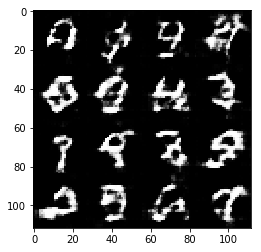

Epoch: 2/2(110)... Discriminator Loss: 1.100362... Generator Loss: 0.880345
Epoch: 2/2(120)... Discriminator Loss: 1.146718... Generator Loss: 1.095528
Epoch: 2/2(130)... Discriminator Loss: 1.174345... Generator Loss: 0.965747
Epoch: 2/2(140)... Discriminator Loss: 1.277189... Generator Loss: 0.938870
Epoch: 2/2(150)... Discriminator Loss: 1.076135... Generator Loss: 0.858267
Epoch: 2/2(160)... Discriminator Loss: 1.108537... Generator Loss: 0.992272
Epoch: 2/2(170)... Discriminator Loss: 1.143537... Generator Loss: 0.861923
Epoch: 2/2(180)... Discriminator Loss: 1.191635... Generator Loss: 0.767265
Epoch: 2/2(190)... Discriminator Loss: 1.289924... Generator Loss: 0.820222
Epoch: 2/2(200)... Discriminator Loss: 1.229488... Generator Loss: 0.839036


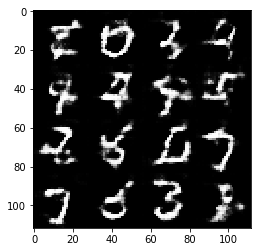

Epoch: 2/2(210)... Discriminator Loss: 1.199215... Generator Loss: 0.863699
Epoch: 2/2(220)... Discriminator Loss: 1.335851... Generator Loss: 0.959613
Epoch: 2/2(230)... Discriminator Loss: 1.318980... Generator Loss: 0.881043
Epoch: 2/2(240)... Discriminator Loss: 1.336330... Generator Loss: 0.696290
Epoch: 2/2(250)... Discriminator Loss: 1.273554... Generator Loss: 0.716141
Epoch: 2/2(260)... Discriminator Loss: 1.160876... Generator Loss: 0.801071
Epoch: 2/2(270)... Discriminator Loss: 1.279636... Generator Loss: 0.860566
Epoch: 2/2(280)... Discriminator Loss: 1.319087... Generator Loss: 0.791225
Epoch: 2/2(290)... Discriminator Loss: 1.231436... Generator Loss: 0.838517
Epoch: 2/2(300)... Discriminator Loss: 1.170158... Generator Loss: 0.930914


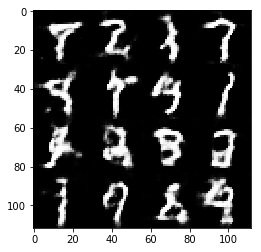

Epoch: 2/2(310)... Discriminator Loss: 1.319427... Generator Loss: 0.706286
Epoch: 2/2(320)... Discriminator Loss: 1.238080... Generator Loss: 0.954199
Epoch: 2/2(330)... Discriminator Loss: 1.156377... Generator Loss: 0.874769
Epoch: 2/2(340)... Discriminator Loss: 1.312914... Generator Loss: 0.771349
Epoch: 2/2(350)... Discriminator Loss: 1.185304... Generator Loss: 0.921429
Epoch: 2/2(360)... Discriminator Loss: 1.178990... Generator Loss: 0.847325
Epoch: 2/2(370)... Discriminator Loss: 1.220941... Generator Loss: 0.888629
Epoch: 2/2(380)... Discriminator Loss: 1.205213... Generator Loss: 0.792849
Epoch: 2/2(390)... Discriminator Loss: 1.264882... Generator Loss: 0.916041
Epoch: 2/2(400)... Discriminator Loss: 1.399867... Generator Loss: 1.027956


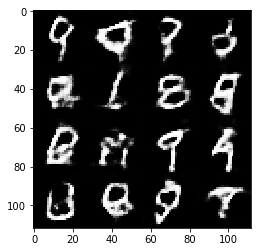

Epoch: 2/2(410)... Discriminator Loss: 1.341363... Generator Loss: 0.685606
Epoch: 2/2(420)... Discriminator Loss: 1.166322... Generator Loss: 0.847383
Epoch: 2/2(430)... Discriminator Loss: 1.197519... Generator Loss: 0.801026
Epoch: 2/2(440)... Discriminator Loss: 1.197958... Generator Loss: 0.944064
Epoch: 2/2(450)... Discriminator Loss: 1.194384... Generator Loss: 0.749662
Epoch: 2/2(460)... Discriminator Loss: 1.214186... Generator Loss: 0.870930
Epoch: 2/2(470)... Discriminator Loss: 1.301866... Generator Loss: 0.757892
Epoch: 2/2(480)... Discriminator Loss: 1.274387... Generator Loss: 0.680625
Epoch: 2/2(490)... Discriminator Loss: 1.255077... Generator Loss: 0.794249
Epoch: 2/2(500)... Discriminator Loss: 1.247648... Generator Loss: 1.057530


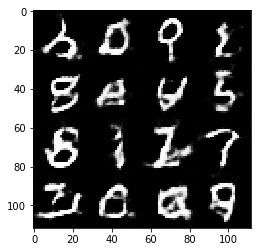

Epoch: 2/2(510)... Discriminator Loss: 1.290405... Generator Loss: 0.781182
Epoch: 2/2(520)... Discriminator Loss: 1.109083... Generator Loss: 0.809718
Epoch: 2/2(530)... Discriminator Loss: 1.155419... Generator Loss: 0.925275
Epoch: 2/2(540)... Discriminator Loss: 1.198021... Generator Loss: 0.810216
Epoch: 2/2(550)... Discriminator Loss: 1.243191... Generator Loss: 0.693532
Epoch: 2/2(560)... Discriminator Loss: 1.260091... Generator Loss: 0.689574
Epoch: 2/2(570)... Discriminator Loss: 1.238420... Generator Loss: 0.778958
Epoch: 2/2(580)... Discriminator Loss: 1.233073... Generator Loss: 0.791270
Epoch: 2/2(590)... Discriminator Loss: 1.249408... Generator Loss: 0.748810
Epoch: 2/2(600)... Discriminator Loss: 1.300948... Generator Loss: 0.779869


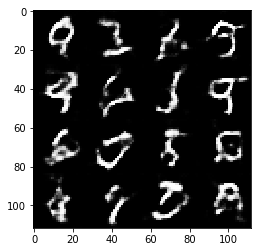

Epoch: 2/2(610)... Discriminator Loss: 1.154464... Generator Loss: 0.766154
Epoch: 2/2(620)... Discriminator Loss: 1.295630... Generator Loss: 0.790153
Epoch: 2/2(630)... Discriminator Loss: 1.209620... Generator Loss: 0.781793
Epoch: 2/2(640)... Discriminator Loss: 1.174643... Generator Loss: 0.898649
Epoch: 2/2(650)... Discriminator Loss: 1.351481... Generator Loss: 0.882576
Epoch: 2/2(660)... Discriminator Loss: 1.270369... Generator Loss: 0.774408
Epoch: 2/2(670)... Discriminator Loss: 1.282827... Generator Loss: 0.798845
Epoch: 2/2(680)... Discriminator Loss: 1.356843... Generator Loss: 0.775560
Epoch: 2/2(690)... Discriminator Loss: 1.285024... Generator Loss: 0.780183
Epoch: 2/2(700)... Discriminator Loss: 1.242020... Generator Loss: 0.755152


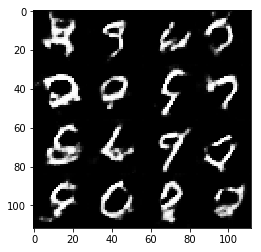

Epoch: 2/2(710)... Discriminator Loss: 1.267981... Generator Loss: 0.792025
Epoch: 2/2(720)... Discriminator Loss: 1.265309... Generator Loss: 0.710531
Epoch: 2/2(730)... Discriminator Loss: 1.225312... Generator Loss: 0.983368
Epoch: 2/2(740)... Discriminator Loss: 1.179103... Generator Loss: 0.737952
Epoch: 2/2(750)... Discriminator Loss: 1.244853... Generator Loss: 0.889737
Epoch: 2/2(760)... Discriminator Loss: 1.163033... Generator Loss: 0.838688
Epoch: 2/2(770)... Discriminator Loss: 1.306276... Generator Loss: 0.827528
Epoch: 2/2(780)... Discriminator Loss: 1.287752... Generator Loss: 0.706800
Epoch: 2/2(790)... Discriminator Loss: 1.289805... Generator Loss: 0.846402
Epoch: 2/2(800)... Discriminator Loss: 1.211737... Generator Loss: 0.815605


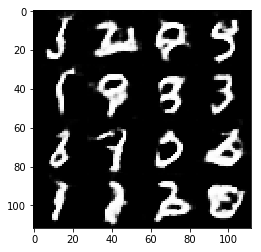

Epoch: 2/2(810)... Discriminator Loss: 1.301667... Generator Loss: 0.699938
Epoch: 2/2(820)... Discriminator Loss: 1.300654... Generator Loss: 0.726372
Epoch: 2/2(830)... Discriminator Loss: 1.279142... Generator Loss: 0.899039
Epoch: 2/2(840)... Discriminator Loss: 1.265620... Generator Loss: 0.838438
Epoch: 2/2(850)... Discriminator Loss: 1.224977... Generator Loss: 0.870825
Epoch: 2/2(860)... Discriminator Loss: 1.429151... Generator Loss: 0.670285
Epoch: 2/2(870)... Discriminator Loss: 1.432841... Generator Loss: 0.709617
Epoch: 2/2(880)... Discriminator Loss: 1.262986... Generator Loss: 0.734619
Epoch: 2/2(890)... Discriminator Loss: 1.268050... Generator Loss: 0.740482
Epoch: 2/2(900)... Discriminator Loss: 1.183468... Generator Loss: 0.946292


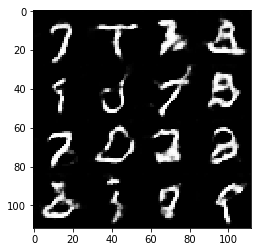

Epoch: 2/2(910)... Discriminator Loss: 1.274885... Generator Loss: 0.799446
Epoch: 2/2(920)... Discriminator Loss: 1.217772... Generator Loss: 0.929198
Epoch: 2/2(930)... Discriminator Loss: 1.270854... Generator Loss: 0.747721


In [158]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1(10)... Discriminator Loss: 1.139352... Generator Loss: 0.599315
Epoch: 1/1(20)... Discriminator Loss: 1.062454... Generator Loss: 0.687589
Epoch: 1/1(30)... Discriminator Loss: 0.851119... Generator Loss: 0.846364
Epoch: 1/1(40)... Discriminator Loss: 0.765907... Generator Loss: 1.032256
Epoch: 1/1(50)... Discriminator Loss: 0.884798... Generator Loss: 1.116016
Epoch: 1/1(60)... Discriminator Loss: 0.861200... Generator Loss: 1.115150
Epoch: 1/1(70)... Discriminator Loss: 1.180895... Generator Loss: 1.008239
Epoch: 1/1(80)... Discriminator Loss: 1.250370... Generator Loss: 0.919090
Epoch: 1/1(90)... Discriminator Loss: 1.159706... Generator Loss: 0.983066
Epoch: 1/1(100)... Discriminator Loss: 1.253992... Generator Loss: 0.898684


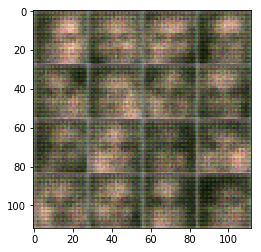

Epoch: 1/1(110)... Discriminator Loss: 1.168301... Generator Loss: 0.983847
Epoch: 1/1(120)... Discriminator Loss: 1.228323... Generator Loss: 0.760706
Epoch: 1/1(130)... Discriminator Loss: 1.199759... Generator Loss: 0.960661
Epoch: 1/1(140)... Discriminator Loss: 1.122033... Generator Loss: 0.889618
Epoch: 1/1(150)... Discriminator Loss: 1.165601... Generator Loss: 0.926027
Epoch: 1/1(160)... Discriminator Loss: 1.277578... Generator Loss: 0.832563
Epoch: 1/1(170)... Discriminator Loss: 1.287562... Generator Loss: 0.778955
Epoch: 1/1(180)... Discriminator Loss: 1.243597... Generator Loss: 0.876654
Epoch: 1/1(190)... Discriminator Loss: 1.162502... Generator Loss: 0.862331
Epoch: 1/1(200)... Discriminator Loss: 1.222152... Generator Loss: 0.844461


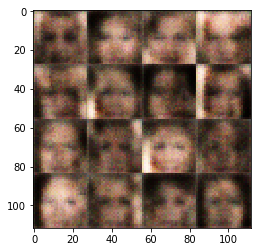

Epoch: 1/1(210)... Discriminator Loss: 1.237659... Generator Loss: 0.772142
Epoch: 1/1(220)... Discriminator Loss: 1.234585... Generator Loss: 0.752515
Epoch: 1/1(230)... Discriminator Loss: 1.207280... Generator Loss: 0.837125
Epoch: 1/1(240)... Discriminator Loss: 1.222681... Generator Loss: 0.734606
Epoch: 1/1(250)... Discriminator Loss: 1.208839... Generator Loss: 0.743519
Epoch: 1/1(260)... Discriminator Loss: 1.162706... Generator Loss: 0.723450
Epoch: 1/1(270)... Discriminator Loss: 1.288587... Generator Loss: 0.813166
Epoch: 1/1(280)... Discriminator Loss: 1.249454... Generator Loss: 0.722434
Epoch: 1/1(290)... Discriminator Loss: 1.314258... Generator Loss: 0.925252
Epoch: 1/1(300)... Discriminator Loss: 1.322907... Generator Loss: 0.731560


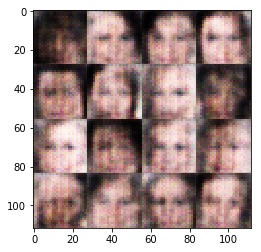

Epoch: 1/1(310)... Discriminator Loss: 1.286632... Generator Loss: 0.789356
Epoch: 1/1(320)... Discriminator Loss: 1.107421... Generator Loss: 0.977333
Epoch: 1/1(330)... Discriminator Loss: 1.357415... Generator Loss: 0.673576
Epoch: 1/1(340)... Discriminator Loss: 1.281190... Generator Loss: 0.738518
Epoch: 1/1(350)... Discriminator Loss: 1.243431... Generator Loss: 0.918636
Epoch: 1/1(360)... Discriminator Loss: 1.341540... Generator Loss: 0.721239
Epoch: 1/1(370)... Discriminator Loss: 1.134678... Generator Loss: 0.846516
Epoch: 1/1(380)... Discriminator Loss: 1.431646... Generator Loss: 0.771238
Epoch: 1/1(390)... Discriminator Loss: 1.203335... Generator Loss: 0.829694
Epoch: 1/1(400)... Discriminator Loss: 1.292696... Generator Loss: 0.732793


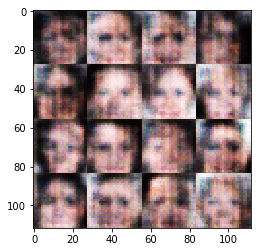

Epoch: 1/1(410)... Discriminator Loss: 1.260618... Generator Loss: 0.750878
Epoch: 1/1(420)... Discriminator Loss: 1.265077... Generator Loss: 0.861316
Epoch: 1/1(430)... Discriminator Loss: 1.481192... Generator Loss: 0.627668
Epoch: 1/1(440)... Discriminator Loss: 1.194337... Generator Loss: 0.756614
Epoch: 1/1(450)... Discriminator Loss: 1.370654... Generator Loss: 0.727283
Epoch: 1/1(460)... Discriminator Loss: 1.390500... Generator Loss: 0.743884
Epoch: 1/1(470)... Discriminator Loss: 1.334349... Generator Loss: 0.707817
Epoch: 1/1(480)... Discriminator Loss: 1.268963... Generator Loss: 0.748260
Epoch: 1/1(490)... Discriminator Loss: 1.355534... Generator Loss: 0.699890
Epoch: 1/1(500)... Discriminator Loss: 1.370724... Generator Loss: 0.722164


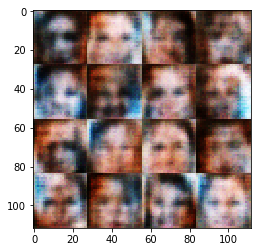

Epoch: 1/1(510)... Discriminator Loss: 1.294010... Generator Loss: 0.738443


In [159]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.